## W3 & W4: Data Engineering (PCA & LDA)

### Objective

Visualizing high dimensional data using the PCA and doing dimensionality reduction to check the explained variance using PCA model. Training a Linear Discriminant Analysis(LDA) model to check if the product has been shipped or canceled.

### Problem Statement

XYZ.com is an e-commerce company based in Argentina. Due to the covid crisis and lockdown XYZ.com is facing lots of issues from the dealer and the shipment team.  XYZ.com has lots of product data where various shipping and sales details of each product have been mentioned. XYZ.com wants to find out which of the products has been shipped and which of the products has been canceled to reduce customer escalation. As a data-scientist, we have to train a PCA model to visualize its higher-dimensional data and we have to train an LDA(Linear Discriminant Analysis) model to predict which of the product has been shipped and which of the product has been canceled.

### 1. Import necessary libraries.

In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
import numpy as np
import re
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial as f
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score
from matplotlib.font_manager import FontProperties
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### 2. Display a sample of five rows of the data frame

In [63]:
df = pd.read_csv('sales_data_sample.csv',encoding='unicode_escape')

In [64]:
df.sample(n=5)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
917,10206,28,67.46,9,1888.88,12/5/2003 0:00,Shipped,4,12,2003,...,1900 Oak St.,NaN,Vancouver,BC,V3F 2K1,Canada,NaN,Tannamuri,Yoshi,Small
234,10357,49,100.00,8,5960.36,12/10/2004 0:00,Shipped,4,12,2004,...,5677 Strong St.,NaN,San Rafael,CA,97562,USA,NaN,Nelson,Valarie,Medium
1382,10276,48,100.00,8,5713.92,8/2/2004 0:00,Shipped,3,8,2004,...,7635 Spinnaker Dr.,NaN,Brickhaven,MA,58339,USA,NaN,Barajas,Miguel,Medium
482,10182,25,87.33,3,2183.25,11/12/2003 0:00,Shipped,4,11,2003,...,5677 Strong St.,NaN,San Rafael,CA,97562,USA,NaN,Nelson,Valarie,Small
1615,10414,23,100.00,10,3335.23,5/6/2005 0:00,On Hold,2,5,2005,...,8616 Spinnaker Dr.,NaN,Boston,MA,51003,USA,NaN,Yoshido,Juri,Medium


### 3. Check the shape of the data (number of rows and column). Check the general information about the dataframe using .info() method.

In [65]:
def basic_info(df):
    '''checking basic information & shape about the dataframe'''
    temp=df.copy(deep=True)
    print("Shape of the dataset",df.shape)
    print("*"*30)
    print(df.info())
    
basic_info(df)

Shape of the dataset (2823, 25)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non

### 4.Check the percentage of missing values in each column of the data frame.

In [66]:
def check_missing_values(df):
    '''Function to check the missing data percentage'''
    print("percentage of missing data of dataframe \n",df.isnull().sum()/len(df)*100)
    
check_missing_values(df)

percentage of missing data of dataframe 
 ORDERNUMBER          0.000000
QUANTITYORDERED      0.000000
PRICEEACH            0.000000
ORDERLINENUMBER      0.000000
SALES                0.000000
ORDERDATE            0.000000
STATUS               0.000000
QTR_ID               0.000000
MONTH_ID             0.000000
YEAR_ID              0.000000
PRODUCTLINE          0.000000
MSRP                 0.000000
PRODUCTCODE          0.000000
CUSTOMERNAME         0.000000
PHONE                0.000000
ADDRESSLINE1         0.000000
ADDRESSLINE2        89.302161
CITY                 0.000000
STATE               52.639036
POSTALCODE           2.692171
COUNTRY              0.000000
TERRITORY           38.044633
CONTACTLASTNAME      0.000000
CONTACTFIRSTNAME     0.000000
DEALSIZE             0.000000
dtype: float64


- Here we can see the column ADDRESSLINE2 has  89.3% of missing values, STATE has 52.6% of missing values.
- POSTALCODE has around 2.69% and TERRITORY has  around 38%.

- We will drop the ADDRESSLINE2 column and impute other columns with most occured values with the respective column.

### 5. Check if there are any duplicate rows.

In [67]:
def check_duplicate(df):
    duplicate=df[df.duplicated()]
    return duplicate

duplicate=check_duplicate(df)
duplicate

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE


- As we can see, There is no duplicate columns which is a good thing for us.

### 6. Write a function that will impute missing values of the columns “STATE”, “POSTALCODE”,“TERRITORY” with its most occurring label.  

In [68]:
def impute_most_occur(df):
    df=df.copy(deep=True)
    temp_state=df['STATE'].value_counts().index[0]
    df['STATE'].fillna(value=temp_state,inplace=True)
    temp_postal_code=df['POSTALCODE'].value_counts().index[0]
    df['POSTALCODE'].fillna(value=temp_postal_code,inplace=True)
    temp_territory=df['TERRITORY'].value_counts().index[0]
    df['TERRITORY'].fillna(value=temp_territory,inplace=True)
    return df

df=impute_most_occur(df)

In [69]:
check_missing_values(df)
print("*"*50)
basic_info(df)

percentage of missing data of dataframe 
 ORDERNUMBER          0.000000
QUANTITYORDERED      0.000000
PRICEEACH            0.000000
ORDERLINENUMBER      0.000000
SALES                0.000000
ORDERDATE            0.000000
STATUS               0.000000
QTR_ID               0.000000
MONTH_ID             0.000000
YEAR_ID              0.000000
PRODUCTLINE          0.000000
MSRP                 0.000000
PRODUCTCODE          0.000000
CUSTOMERNAME         0.000000
PHONE                0.000000
ADDRESSLINE1         0.000000
ADDRESSLINE2        89.302161
CITY                 0.000000
STATE                0.000000
POSTALCODE           0.000000
COUNTRY              0.000000
TERRITORY            0.000000
CONTACTLASTNAME      0.000000
CONTACTFIRSTNAME     0.000000
DEALSIZE             0.000000
dtype: float64
**************************************************
Shape of the dataset (2823, 25)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data 

### 7. Drop “ADDRESSLINE2”,”ORDERDATE”,”PHONE” column.

In [70]:
df.drop(['ADDRESSLINE2','ORDERDATE','PHONE'],axis=1,inplace=True)

In [71]:
check_missing_values(df)
print("*"*50)
basic_info(df)

percentage of missing data of dataframe 
 ORDERNUMBER         0.0
QUANTITYORDERED     0.0
PRICEEACH           0.0
ORDERLINENUMBER     0.0
SALES               0.0
STATUS              0.0
QTR_ID              0.0
MONTH_ID            0.0
YEAR_ID             0.0
PRODUCTLINE         0.0
MSRP                0.0
PRODUCTCODE         0.0
CUSTOMERNAME        0.0
ADDRESSLINE1        0.0
CITY                0.0
STATE               0.0
POSTALCODE          0.0
COUNTRY             0.0
TERRITORY           0.0
CONTACTLASTNAME     0.0
CONTACTFIRSTNAME    0.0
DEALSIZE            0.0
dtype: float64
**************************************************
Shape of the dataset (2823, 22)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   P

### 8. Convert the labels of the STATUS column to 0 and 1. For Shipped assign value 1 and for all other labels (i.e. ‘Cancelled’,’ Resolved’,’ On Hold’,’ In Process’, 'Disputed') assign 0. Note we will consider everything apart from Shipped as cancel (i.e. 0).


In [72]:
df['STATUS']=df['STATUS'].map({'Shipped':1,'Cancelled':0,'Resolved':0,'On Hold':0,'In Process':0,'Disputed':0})

In [73]:
df['STATUS'].value_counts()

1    2617
0     206
Name: STATUS, dtype: int64

### 9. Assign ‘STATUS’ column into a label variable and drop it from the original dataframe.Convert the original dataframe to the dummy coded data.(Hint:-use pd.get_dummies()).

In [74]:
lv=df['STATUS']
df.drop(['STATUS'],axis=1,inplace=True)

In [75]:
new_df=pd.get_dummies(df)

In [76]:
new_df.shape

(2823, 645)

### 10. Use StandardScaler to scale the data.

In [77]:
standardized_data=StandardScaler().fit_transform(new_df)
print(standardized_data.shape)

(2823, 645)


## PCA for Visualization 

### 1.Take the help of PCA to reduce the data to 2 dimensions. Use n_components=2. 

In [78]:
sample_data=standardized_data
pca=PCA()
pca.n_components=2
pca_data=pca.fit_transform(sample_data)
print("Reduced dimension=",pca_data.shape)

Reduced dimension= (2823, 2)


### 2.Take the first and second principal components and plot a scatter plot with the labels. 

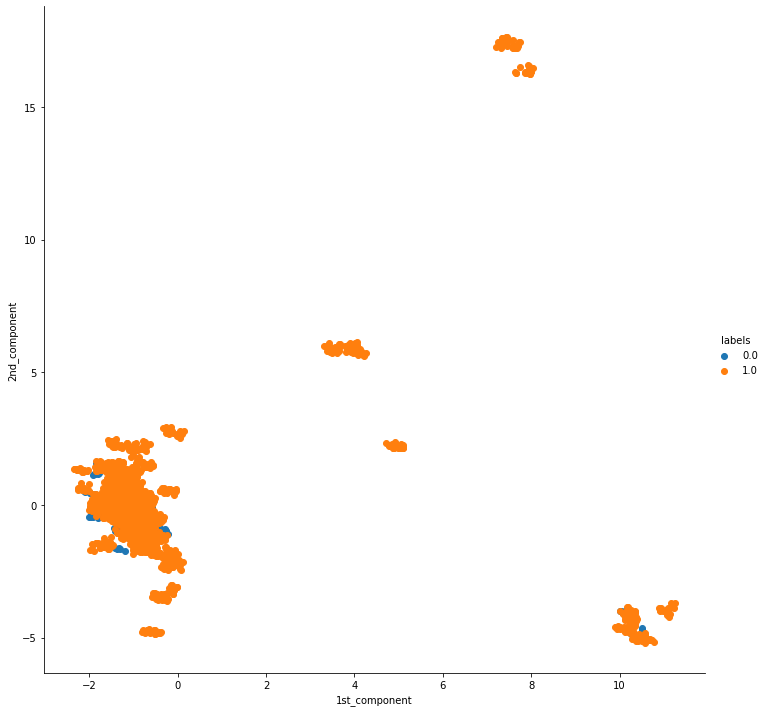

In [79]:
pca_data=np.vstack((pca_data.T,lv)).T
pca_df=pd.DataFrame(data=pca_data,columns=("1st_component","2nd_component","labels"))
sns.FacetGrid(pca_df,hue='labels',size=10).map(plt.scatter,"1st_component","2nd_component").add_legend()
plt.show()

### 3. Write the intuitions about the scatter plot.

- Most of the data are overlapping with each other.
- As we can see, data's are coming in clusters.

## PCA for dimensionality Reduction 

### 1. Fit the PCA model on the data and plot a graph between n_components and cumulative explained variance.

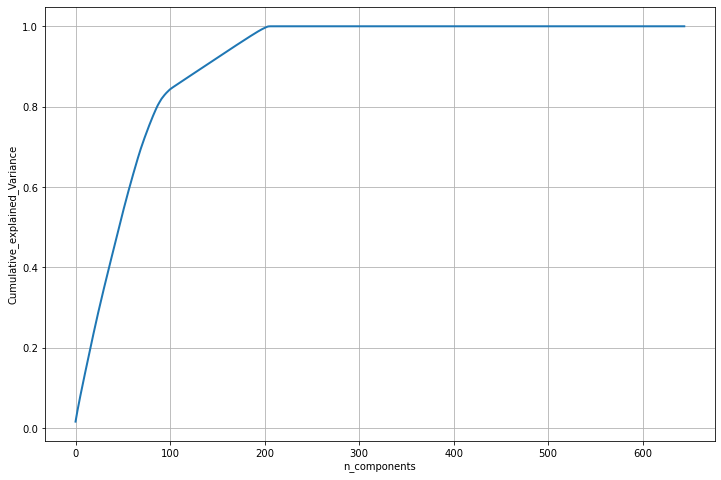

In [80]:
pca=PCA()
pca.n_components=645
pca_data=pca.fit_transform(sample_data)
percentage_var_explained=pca.explained_variance_/np.sum(pca.explained_variance_)

cum_var_explained=np.cumsum(percentage_var_explained)

plt.figure(1,figsize=(12,8))
plt.clf()
plt.plot(cum_var_explained,linewidth=2)
plt.axis=('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_Variance')
plt.show()

- From the above diagram it is clear that by taking around 150 components we will be able to get 90% varaiance.

## LDA 

### 1. Split the dataset into two parts (i.e. 80% train and 20% test) using random_state=42. 

In [81]:
sample_data.shape,lv.shape

((2823, 645), (2823,))

In [82]:
label = lv.to_numpy()
lv_mat = label.reshape(-1,1)

In [83]:
X_train,X_test,y_train,y_test=train_test_split(sample_data,lv_mat,test_size=0.2,random_state=42)

In [84]:
rf=RandomForestClassifier(max_depth=3,n_estimators=25)
rf.fit(X_train,y_train)
y_train_pred=rf.predict(X_train)
y_test_pred=rf.predict(X_test)

print("Train Accuracy",accuracy_score(y_train,y_train_pred))
print("Test Accuracy",accuracy_score(y_test,y_test_pred))
print("*"*50)
print("Train confusion matrix",confusion_matrix(y_train,y_train_pred))
print("Test confusion matrix",confusion_matrix(y_test,y_test_pred))

Train Accuracy 0.9317980513728964
Test Accuracy 0.9079646017699115
**************************************************
Train confusion matrix [[   0  154]
 [   0 2104]]
Test confusion matrix [[  0  52]
 [  0 513]]


### 2. Train a Linear Discriminant Analysis(LDA) model on the train data. Do fit_transform on the train data and only transform on the test data. 

In [85]:
lda = LDA(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [86]:
X_train[:5],X_test[:5]

(array([[ 0.60496511],
        [ 0.28984435],
        [ 0.6028427 ],
        [-0.21719613],
        [ 0.27988057]]),
 array([[ 1.26394182],
        [ 2.52900911],
        [ 1.33478261],
        [-2.94060547],
        [ 0.7395123 ]]))

### 3.Train a random-forest model on the transformed data  and print the accuracy of train and test data. Take max_depth=3 and n_estimators=25 

In [87]:
rf=RandomForestClassifier(max_depth=3,n_estimators=25)
rf.fit(X_train,y_train)
y_train_pred=rf.predict(X_train)
y_test_pred=rf.predict(X_test)

print("Train Accuracy",accuracy_score(y_train,y_train_pred))
print("Test Accuracy",accuracy_score(y_test,y_test_pred))
print("*"*50)
print("Train confusion matrix",confusion_matrix(y_train,y_train_pred))
print("Test confusion matrix",confusion_matrix(y_test,y_test_pred))

Train Accuracy 0.953941541186891
Test Accuracy 0.911504424778761
**************************************************
Train confusion matrix [[  86   68]
 [  36 2068]]
Test confusion matrix [[ 14  38]
 [ 12 501]]


### Conclusion 

- As we can see we True negative and False negative points is zero before applying LDA but after applying LDA we are getting some amount of True negative and false negative points.
- Due to class imbalance, the majority class has high recall but minority class has poor recall.


### Happy Learning:)